In [24]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"


In [25]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [59]:
parameter_values.search("thickness")

Initial inner SEI thickness [m]	2.5e-09
Initial outer SEI thickness [m]	2.5e-09
Negative current collector thickness [m]	2.5e-05
Negative electrode thickness [m]	6.2e-05
Positive current collector thickness [m]	2.5e-05
Positive electrode thickness [m]	6.7e-05
Separator thickness [m]	1.2e-05


In [27]:
cell = 1

In [28]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339


In [29]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 

In [30]:
c_rate_c = 'C/5'
c_rate_d = 'C/5'
sim_des = 'low_c'
# c_rate_c = '1C'
# c_rate_d = '1C'
# sim_des = 'high_c'
dis_set = " until 3V"
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Charge at "+c_rate_c+" until 4.2V", )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        "pressure driven porosity": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [31]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [50]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        # "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        # "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant proportional term [s-1]": 8.7864e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.08031e-05,
        "SEI kinetic rate constant [m.s-1]": 1.6297e-15,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)

In [33]:
sim_0 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_0 = sim_0.solve(initial_soc=0)

In [34]:
t_0 = sol_0["Time [min]"].entries
x = sol_0["x [m]"].entries
x_n = sol_0["x_n [m]"].entries

In [35]:
spm.variables.search("[s]")

Time [s]


In [36]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        # "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        # "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant proportional term [s-1]": 8.7864e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.08031e-05,
        "EC diffusivity [m2.s-1]": 1.6297e-15,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Negative electrode porosity": 0.15,
        "Positive electrode porosity": 0.15,
        "Separator porosity": 0.2,
    },
    check_already_exists=False,
)

In [37]:
sim_1 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_1 = sim_1.solve(initial_soc=0)

In [38]:
t_1 = sol_1["Time [min]"].entries

In [39]:
c_e_0 = sol_0["Electrolyte concentration [mol.m-3]"].entries
c_e_1 = sol_1["Electrolyte concentration [mol.m-3]"].entries

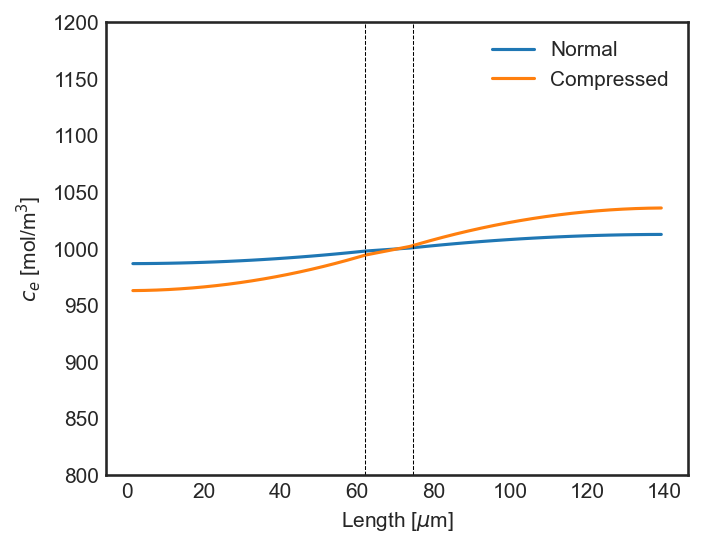

In [40]:
fig = plt.figure(figsize=[5,4])
ax1 = plt.subplot(1,1,1)
ax1.plot(x[:,50]*1e6,c_e_0[:,50])
ax1.plot(x[:,50]*1e6,c_e_1[:,50])
ax1.axvline(x=62,color='k', linestyle='--',linewidth=0.5)
ax1.axvline(x=62+12.5,color='k', linestyle='--',linewidth=0.5)
ax1.set_xlabel('Length [$\mu$m]')
ax1.set_ylim([800,1200])
ax1.set_ylabel('$c_e$ [mol/m$^3$]')
ax1.legend(['Normal', 'Compressed'])
fig.savefig(fig_DIR +'electrolyte_conc_' +sim_des +'_.png')

## Electrolyte Potential

In [41]:
phi_e_0 = sol_0["Electrolyte potential [V]"].entries
phi_e_1 = sol_1["Electrolyte potential [V]"].entries

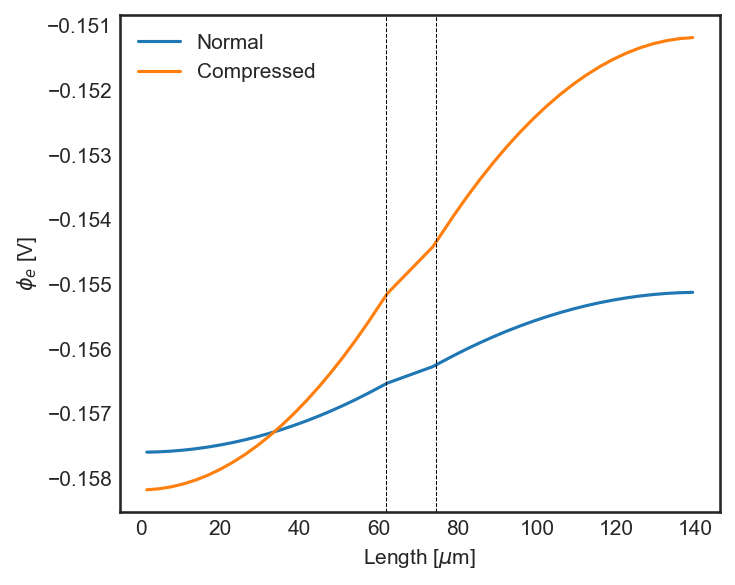

In [47]:
fig = plt.figure(figsize=[5,4])
ax1 = plt.subplot(1,1,1)
ax1.plot(x[:,50]*1e6,phi_e_0[:,50])
ax1.plot(x[:,50]*1e6,phi_e_1[:,50])
ax1.axvline(x=62,color='k', linestyle='--',linewidth=0.5)
ax1.axvline(x=62+12.5,color='k', linestyle='--',linewidth=0.5)
ax1.set_xlabel('Length [$\mu$m]')
# ax1.set_ylim([-0.2,0])
ax1.set_ylabel('$\phi_e$ [V]')
ax1.legend(['Normal', 'Compressed'])
fig.tight_layout()
fig.savefig(fig_DIR +'electrolyte_pot_'+sim_des+'_.png')

## SEI Overpotential

In [43]:
eta_sei_avg_0 = sol_0["X-averaged SEI film overpotential [V]"].entries
eta_sei_avg_1 = sol_1["X-averaged SEI film overpotential [V]"].entries
eta_sei_0 = sol_0["SEI film overpotential [V]"].entries
eta_sei_1 = sol_1["SEI film overpotential [V]"].entries


In [44]:
eta_sei_0

array([[5.46764877e-05, 5.46765010e-05, 5.46765507e-05, ...,
        5.87418064e-05, 5.87643106e-05, 5.87678867e-05],
       [5.46764877e-05, 5.46765010e-05, 5.46765507e-05, ...,
        5.87418064e-05, 5.87643106e-05, 5.87678867e-05],
       [5.46764877e-05, 5.46765010e-05, 5.46765507e-05, ...,
        5.87418064e-05, 5.87643106e-05, 5.87678867e-05],
       ...,
       [5.46764877e-05, 5.46765010e-05, 5.46765507e-05, ...,
        5.87418064e-05, 5.87643106e-05, 5.87678867e-05],
       [5.46764877e-05, 5.46765010e-05, 5.46765507e-05, ...,
        5.87418064e-05, 5.87643106e-05, 5.87678867e-05],
       [5.46764877e-05, 5.46765010e-05, 5.46765507e-05, ...,
        5.87418064e-05, 5.87643106e-05, 5.87678867e-05]])

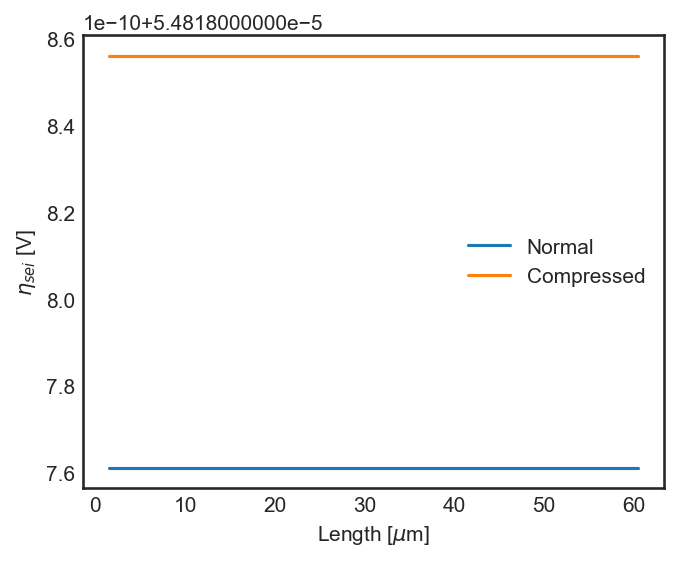

In [45]:
fig = plt.figure(figsize=[5,4])
ax1 = plt.subplot(1,1,1)
ax1.plot(x_n[:,50]*1e6,eta_sei_0[:,50])
ax1.plot(x_n[:,50]*1e6,eta_sei_1[:,50])
# ax1.axvline(x=62,color='k', linestyle='--',linewidth=0.5)
# ax1.axvline(x=62+12.5,color='k', linestyle='--',linewidth=0.5)
ax1.set_xlabel('Length [$\mu$m]')
# ax1.set_ylim([-0.2,0])
ax1.set_ylabel('$\eta_{sei}$ [V]')
ax1.legend(['Normal', 'Compressed'])
fig.savefig(fig_DIR +'sei_overpot_l_'+sim_des+'_.png')

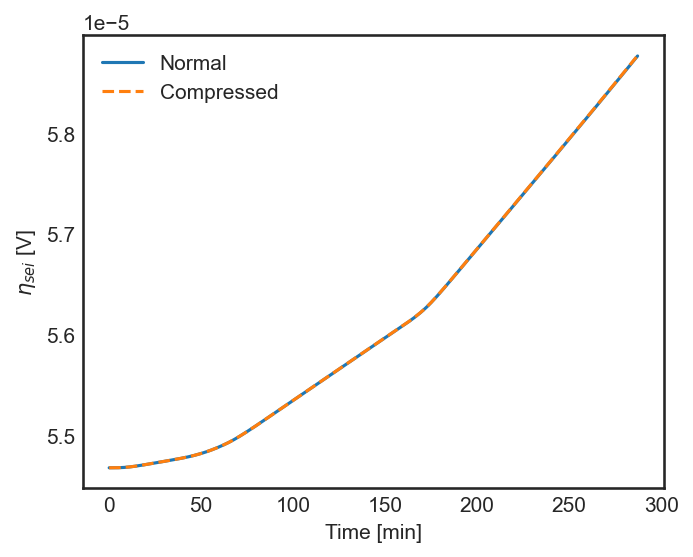

In [46]:
fig = plt.figure(figsize=[5,4])
ax1 = plt.subplot(1,1,1)
ax1.plot(t_0,eta_sei_0[10,:])
ax1.plot(t_1,eta_sei_1[10,:],'--')
# ax1.axvline(x=62,color='k', linestyle='--',linewidth=0.5)
# ax1.axvline(x=62+12.5,color='k', linestyle='--',linewidth=0.5)
ax1.set_xlabel('Time [min]')
# ax1.set_ylim([-0.2,0])
ax1.set_ylabel('$\eta_{sei}$ [V]')
ax1.legend(['Normal', 'Compressed'])
fig.savefig(fig_DIR +'sei_overpot_t_'+sim_des+'_.png')

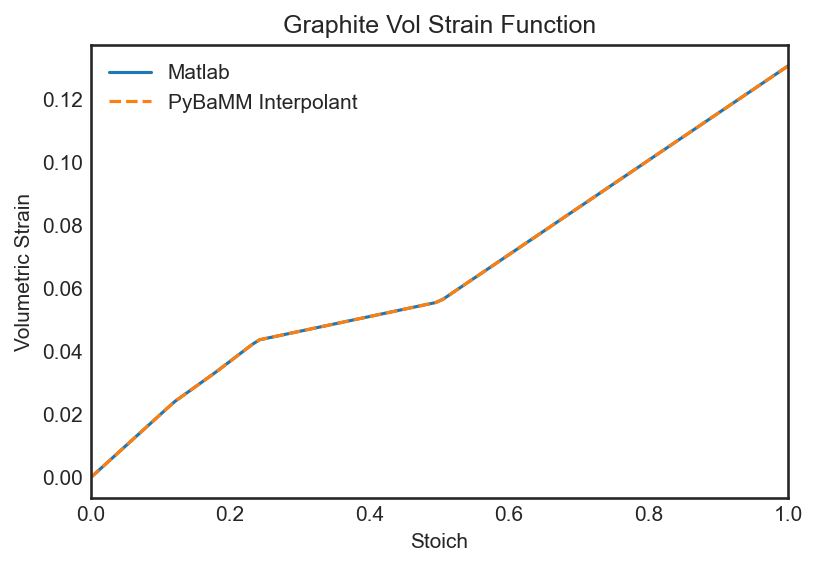

In [55]:
def graphite_volume_change(sto):
    a = 0.50
    b = 0.24
    c = 0.18 
    d = 0.12
    t_change = (
        (0 <= sto and sto < d)*(2.4060/d*sto)+
        (d <= sto and sto < c)*(-(2.4060-3.3568)/(c-d)*(sto-d)+2.4060)+
        (c <= sto and sto < b)*(-(3.3568-4.3668)/(b-c)*(sto-c)+3.3568)+
        (b <= sto and sto < a)*(-(4.3668-5.5830)/(a-b)*(sto-b)+4.3668)+
        (a <= sto and sto <= 1)*(-(5.583-13.0635)/(1-a)*(sto-a)+5.583)
    )
    t_change = t_change/100
    return t_change
sto = np.linspace(0,1,100)
yout = np.zeros(len(sto))
yout1 = np.zeros(len(sto))
for i in range(len(sto)):
    yout[i] = graphite_volume_change(sto[i])
    yout1[i] = graphite_volume_change_mohtat(sto[i]).evaluate()
plt.figure()
plt.plot(sto,yout)
plt.plot(sto,yout1,'--')
plt.xlim([0,1])
plt.legend(['Matlab','PyBaMM Interpolant'])
plt.xlabel('Stoich')
plt.ylabel('Volumetric Strain')
plt.title('Graphite Vol Strain Function')
plt.savefig('exp_func')